In [1]:
# load functions for data analysis
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy, sys
import seaborn as sns
import numpy as np
from scipy import stats
pandas.options.mode.chained_assignment = None
sns.set_style("dark", {'axes.grid' : False})

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# scr data anslysis functions
sys.path.append(os.getcwd() + '/scr/')
from scr_analysis_functions_fyp import experimental
# behavioral analysis functions
sys.path.append(os.getcwd() + '/self_report/')
import behavioral_analysis_functions as behavioral_functions

In [4]:
# paths to scr and behavioral data
scr_data_path =  os.getcwd() + '/scr/data_study_one'
behavioral_data_path = os.getcwd() + '/self_report/data_study_one/'

In [5]:
results_folder = 'results/figures'

In [6]:
day_one = experimental(scr_data_path)
day_one.day = 1
day_one.preprocessData()

In [7]:
day_two = experimental(scr_data_path)
day_two.day = 2
day_two.preprocessData()

In [8]:
def show_subject_scr_across_experiment(): 
    
    figure(figsize=[20,4])
    i_subject = 5
    sns.set_style("white", {'axes.grid' : False})
    offset = 1
    _alpha_ = .1
    _subject_data_ = day_one.transData[i_subject][0]
    _cs_plus_ = day_one.transData[i_subject][1][:,0]
    _cs_minus_ = day_one.transData[i_subject][1][:,1]
    _us_ = day_one.transData[i_subject][1][:,2]

    plot(_subject_data_, label='SCR', linewidth=2, color='xkcd:black')
    plot(3* _cs_plus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:red', label='CS+')
    plot(3* _cs_minus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:blue', label='CS-')
    plot(3* _us_-5, linewidth=2, alpha=.5, color='crimson', label='US')

    ylim([np.min(day_one.transData[i_subject][0])-offset,np.max(day_one.transData[i_subject][0])+offset])
    xlim([0, len(day_one.transData[i_subject][1][:,1])]); xticks([]) ; yticks([])
    ylabel('z-scored\nskin conductance response', fontsize=15, fontweight='bold')
    title('Skin conductance response of a single subject across day one', y=1.1, fontsize=30, fontweight='bold')
    xlabel('\ntime', fontsize=15, fontweight='bold')
    legend(bbox_to_anchor=(1, .9), fontsize=25); 
    savefig('%s/study_one_scr_timecourse_single_subject.png'%results_folder,  bbox_inches='tight',)
    

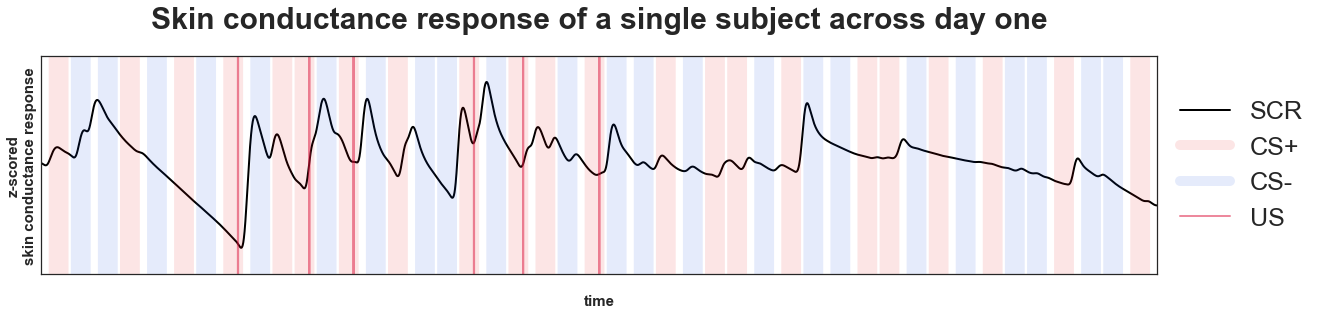

In [9]:
show_subject_scr_across_experiment()

In [10]:
def show_group_average_scr_across_experiment(): 
    
    min_len = np.array([np.shape(day_one.transData[i][0])[0] for i in range(len(day_one.transData))]).min()
    average_scr = np.array([np.array(day_one.transData[i_subject][0][0:min_len]) for i_subject in range(len(day_one.transData))]).mean(0)
    
    figure(figsize=[20,4])
    offset = 1
    _alpha_ = .1
    _cs_plus_ = day_one.transData[i_subject][1][:,0]
    _cs_minus_ = day_one.transData[i_subject][1][:,1]
    _us_ = day_one.transData[i_subject][1][:,2]

    plot(average_scr, label='SCR', linewidth=2, color='xkcd:black')
    plot(3* _cs_plus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:red', label='CS+')
    plot(3* _cs_minus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:blue', label='CS-')
    plot(3* _us_-5, linewidth=2, alpha=1, color='crimson', label='US')

    ylim([np.min(average_scr)-offset,np.max(average_scr)+offset])
    xlim([0, len(day_one.transData[i_subject][1][:,1])]); xticks([]) ; yticks([])
    ylabel('z-scored\nskin conductance response', fontsize=15, fontweight='bold')
    xlabel('\ntime', fontsize=15, fontweight='bold')
    title('Skin conductance response averaged across all subjects on day one', y=1.1, fontsize=30, fontweight='bold')
    xlabel('\ntime', fontsize=15, fontweight='bold')
    legend(bbox_to_anchor=(1, .9), fontsize=26); 
    savefig('%s/study_one_scr_timecourse_averaged_subjects.png'%results_folder, bbox_inches='tight')

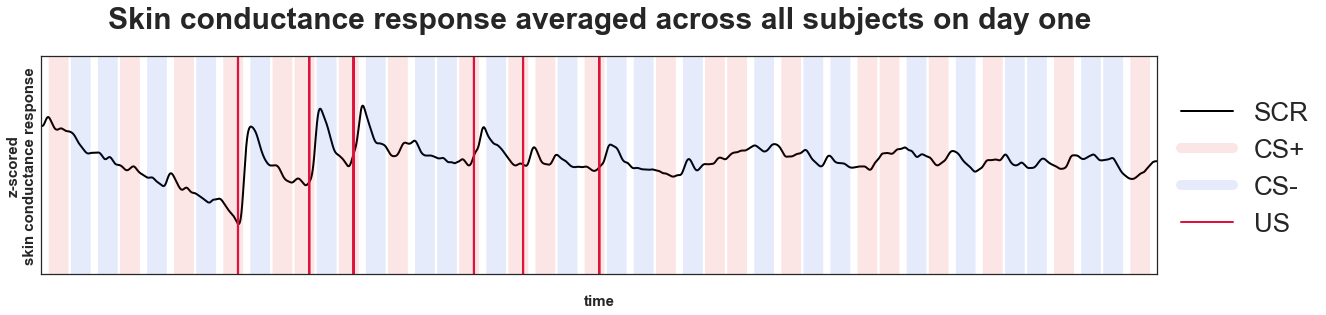

In [11]:
show_group_average_scr_across_experiment()

In [12]:
def counterbalance_info(_data_): 
    
    cb, bc, order = [], [], np.zeros(_data_.nSubjects)

    for iSubject in range(0,len(_data_.subjectNames)): 
        
        if str.find(_data_.subjectNames[iSubject], '_cb_') != -1: cb.append(iSubject)
        else: bc.append(iSubject)
            
    order[cb] = 1
    
    _dict_ = {'counter_balanced_inds':np.array(cb), 
              'not_counter_balanced_inds': np.array(bc), 
              'order': order} 

    return _dict_

In [13]:
def log_transform(_a_): 
    """convenience function"""
    return np.log(1 + _a_)

In [14]:
def extract_conditioning_data(scr_data_, type_ , location_, dict_=''):
    '''
    scr_data_ is either day_one or day_two
    type_ is either 'raw' or 'trans'
    location_ is either 'onset' (predictive) or 'offset' (contagion)
    '''
    
    if not dict_: dict_ = {}
    
    dict_['%s_%s'%(type_, location_)] = {} 
    
    if location_ == 'onset':
        # look at all onsets after the initial shock, during conditioning
        start_ind, end_ind = 4, 13 
        trial_ = list(range(start_ind, end_ind))
        positive_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
        negative_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
    else: 
        # only look at offsets when the model was shocked
        trial_ = np.array([3, 5, 6, 8, 9, 11])
        positive_ = np.zeros([scr_data_.nSubjects,len(trial_)])
        negative_ = np.zeros([scr_data_.nSubjects,len(trial_)])
    
    for i_stim in range(0,len(trial_)):
        positive_[:,i_stim], negative_[:,i_stim] = scr_data_.amplitudeDifference(type_, trial_[i_stim], location_);

    significance_ = np.zeros(scr_data_.nSubjects)
    for iSubject in range(0,scr_data_.nSubjects): 
        significance_[iSubject] = scipy.stats.ttest_ind(positive_[iSubject,:], negative_[iSubject,:])[1];

    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(positive_)
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(negative_)
    dict_['%s_%s'%(type_, location_)]['significe_difference'] = significance_
    dict_['%s_%s'%(type_, location_)]['learning'] = mean(log_transform(positive_) - log_transform(negative_),1)
    
    return dict_

In [15]:
def extract_renewal_data(day_two, type_, location_, dict_=''): 
        
    if not dict_: dict_ = {} 
    dict_['%s_%s'%(type_, location_)] = {} 
        
    plus, minus = day_two.amplitudeDifference(type_, 0, location_);
    
    dict_['%s_%s'%(type_, location_)]['contrast'] = log_transform(plus) - log_transform(minus) 
    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(plus) 
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(minus)
    
    return dict_


In [16]:

def test_single_relationship(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[0,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)

def control_for_order(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ C(order) + %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[1,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)
    
def full_model(_df_): 
    formula = 'renewal ~ C(order) +  prediction + contagion'
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[1,3]
    print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
def show_first_contagion_response(_cndioning_): 

    _pos_ = _cndioning_['trans_offset']['positive_stim'][:,0]
    _neg_ = _cndioning_['trans_offset']['negative_stim'][:,0]
    p_val = stats.ttest_ind(_pos_,_neg_)[1]
    
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    _plus_color, _minus_color = 'xkcd:red', 'xkcd:blue'
    
    _alpha_, _scale = .5, 30
    n_points = len(_pos_)
    _jitter1 = np.random.randn(n_points)/_scale
    _jitter2 = np.random.randn(n_points)/_scale

    scatter(np.ones(n_points) + _jitter1, _neg_, s=500, color='white')
    scatter(np.zeros(n_points) + _jitter2, _pos_, s=500,  color='white')  
    scatter(np.ones(n_points) + _jitter1, _neg_, label='CS-', s=150, color=_minus_color, alpha=_alpha_)
    scatter(np.zeros(n_points) + _jitter2, _pos_, label='CS+', s=150, color=_plus_color, alpha=_alpha_)
    ylabel('Magnitude of SCR\n', rotation=90, fontsize=20, fontweight='bold')

    yticks([0,.5,],[ 0.,.5], fontsize=15); xlim(-.5, 1.5) ; ylim(-.5, 3)
    xticks([0, 1],['\nCS+','\nCS-'], fontsize=18, fontweight='bold')
    title('\nSubjects show differential response to US (p < %.1e)\n'%p_val, 
          fontsize=18,fontweight='bold'); 
    savefig('%s/study_one_first_us.png'%results_folder, bbox_inches='tight')
    
    return _pos_ - _neg_ 
    

In [17]:
def show_order_effects(): 
    
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(order))/100
    scatter(order + jitter,log_renewal, alpha=.8, s=90)
    scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([-.5,0,.5,],[-.5,0,.5])
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    xlim(-.2, 1.2)
    ylim(-2.5, 3)
    title('Main Effect of order on SCR to CS on day two (p < %.04f)\n'%p_val_order_effects, fontsize=15); 


In [18]:
# extract measure of predictive learning across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'onset')
# extract measure of emotional contagion across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'offset', conditioning)
# extract measure for determining non-responders
conditioning = extract_conditioning_data(day_one, 'raw', 'onset', conditioning)

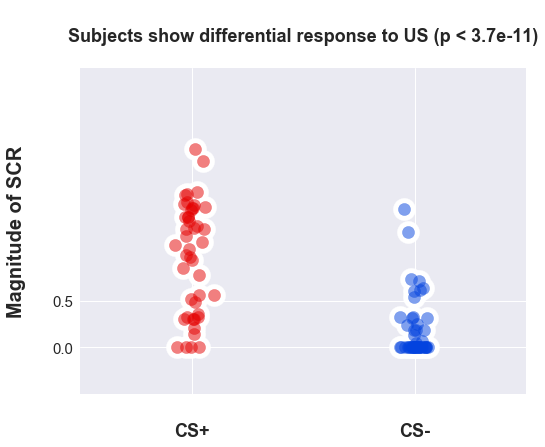

In [19]:
conditioning['trans_onset']['initial_difference_contagion'] = show_first_contagion_response(conditioning)

In [20]:
# renewal measure -- main dependent variable of the experiment 
renewal = extract_renewal_data(day_two, 'trans', 'onset')
renewal = extract_renewal_data(day_two, 'raw',   'onset', renewal)

In [21]:
# extract information about the order of presentation of day two
counter_balance_info = counterbalance_info(day_two)

In [22]:
# set criteria for responders -- at least one scr responce > .1
responders = np.array(conditioning['raw_onset']['positive_stim'] > .1).mean(1) > 0

In [23]:
# reformat into a data frame
SCR = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'],
                        'order':counter_balance_info['order'],
                        'contagion':conditioning['trans_offset']['learning'],
                        'prediction': conditioning['trans_onset']['learning'], 
                        'contagion_initial_diff': conditioning['trans_onset']['initial_difference_contagion']})

In [24]:
# remove non-responders 
responders_data = SCR[responders]

In [25]:
# determine significance and display
renewal['significance'] = {} 
renewal['significance']['order'] = test_single_relationship(responders_data, 'order')


		renewal ~ order 

             sum_sq    df          F    PR(>F)
order     10.131943   1.0  20.795138  0.000092
Residual  13.642343  28.0        NaN       NaN 



In [26]:
def show_order_effects(): 
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(counter_balance_info['order']))/100
    _alpha_ = .6
    _scale = 30
    _jitter1 =  np.random.randn(np.sum(counter_balance_info['order']==0))/_scale
    _jitter2 = np.random.randn(np.sum(counter_balance_info['order']==1))/_scale
    _jitter3 = np.random.randn(np.sum(counter_balance_info['order']==1))/_scale
    _jitter4 = np.random.randn(np.sum(counter_balance_info['order']==0))/_scale

    _plus_color = 'xkcd:red'
    _minus_color = 'xkcd:blue'
    scatter(np.ones(np.sum(counter_balance_info['order']==0)) + _jitter1, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==0], s=500, color='white')
    scatter(np.zeros(np.sum(counter_balance_info['order']==1)) + _jitter2, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==1], s=500,  color='white')
    scatter(np.ones(np.sum(counter_balance_info['order']==1)) + _jitter3, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==1], s=500, color='white')
    scatter(np.zeros(np.sum(counter_balance_info['order']==0)) + _jitter4, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==0],s=500, color='white')
    
    scatter(np.ones(np.sum(counter_balance_info['order']==0)) + _jitter1, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==0], 
            label='CS-', s=150, color=_minus_color, alpha=_alpha_)
    scatter(np.zeros(np.sum(counter_balance_info['order']==1)) + _jitter2, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==1], 
            s=150, color=_minus_color, alpha=_alpha_)
    scatter(np.ones(np.sum(counter_balance_info['order']==1)) + _jitter3, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==1], 
            label='CS+', s=150, color=_plus_color, alpha=_alpha_)
    scatter(np.zeros(np.sum(counter_balance_info['order']==0)) + _jitter4, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==0],
            s=150, color=_plus_color, alpha=_alpha_)
    
    legend(bbox_to_anchor=(1, 1), fontsize=20)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([0,.5,],[ 0,.5]); xlim(-.5, 1.5) ; ylim(-.5, 3)
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    title('\nMain Effect of order on skin conductance \nresponse to CS on day two (p < %.04f)\n'
          %renewal['significance']['order'], fontsize=20,fontweight='bold'); 
    savefig('%sstudy_one_order_effects.png'%results_folder, bbox_inches='tight')
    

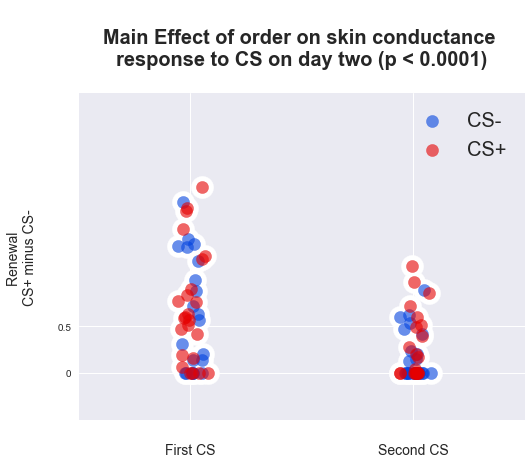

In [27]:
show_order_effects()

In [28]:
renewal['significance']['prediction']  = test_single_relationship(responders_data, 'prediction')


		renewal ~ prediction 

               sum_sq    df          F    PR(>F)
prediction   6.568438   1.0  10.689172  0.002855
Residual    17.205848  28.0        NaN       NaN 



In [29]:
renewal['significance']['contagion']   = test_single_relationship(responders_data, 'contagion')


		renewal ~ contagion 

              sum_sq    df         F    PR(>F)
contagion   0.047000   1.0  0.055464  0.815529
Residual   23.727286  28.0       NaN       NaN 



In [30]:
renewal['significance']['prediction_controlled'] = control_for_order(responders_data, 'prediction')


		renewal ~ C(order) + prediction 

               sum_sq    df          F    PR(>F)
C(order)     6.383237   1.0  15.924754  0.000454
prediction   2.819733   1.0   7.034604  0.013222
Residual    10.822610  27.0        NaN       NaN 



In [31]:
renewal['significance']['contagion_controlled']  = control_for_order(responders_data, 'contagion')


		renewal ~ C(order) + contagion 

              sum_sq    df          F    PR(>F)
C(order)   10.333372   1.0  20.830433  0.000098
contagion   0.248429   1.0   0.500793  0.485216
Residual   13.393914  27.0        NaN       NaN 



In [32]:
full_model(responders_data)


		renewal ~ C(order) +  prediction + contagion 

               sum_sq    df          F    PR(>F)
C(order)     5.783204   1.0  13.967033  0.000924
prediction   2.628327   1.0   6.347679  0.018235
contagion    0.057023   1.0   0.137716  0.713569
Residual    10.765587  26.0        NaN       NaN 



In [33]:
def show_relationships(): 
    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})
    subplot(121)
    type_color = 'xkcd:indigo'
    scatter(SCR['contagion'],SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    scatter(SCR['contagion'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['contagion'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    legend( bbox_to_anchor=(.20, 1, 1, -.1), fontsize=13)
    xlabel('Emotional contagion on day one\n CS+ minus CS- at shock offset',fontsize=13, fontweight='bold')
    ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13, fontweight='bold')
    #xlim(-.4,1)
    title('Relationship between emotional contagion and renewal (p < %.1f)\n' 
          %(renewal['significance']['contagion']), fontsize=18, fontweight='bold'); 

    subplot(122)
    type_color = 'xkcd:indigo'
    scatter(SCR['prediction'], SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    #scatter(log_learning[responders == True], log_renewal[responders == True],color='yellow',alpha=1,s=300, label='responders')

    scatter(SCR['prediction'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['prediction'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    xlabel('Predictive learning on day one\n CS+ minus CS- at stimulus onset',fontsize=13, fontweight='bold')
    yticks([-.1,0,.1],['','',''])
    title('\n Relationship between predictive learning and renewal (p < %.3f)\n' 
          %(renewal['significance']['prediction']), fontsize=18, fontweight='bold'); 
    t = suptitle('Relationship between learning measures on day one with renewal', y =1.15, fontsize=20, fontweight='bold')
    
    savefig('%sday_one_scr_comparision.png'%results_folder, bbox_extra_artists=[t])

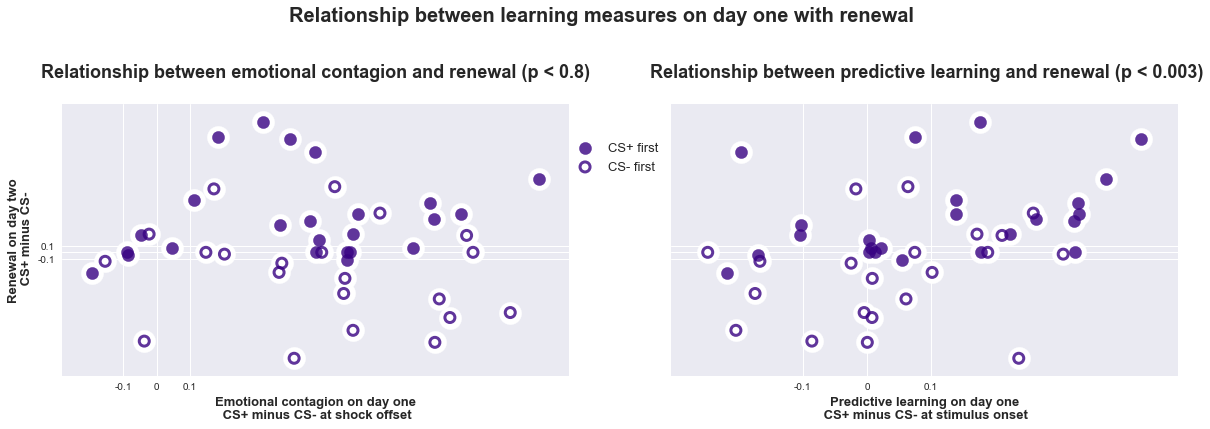

In [34]:
show_relationships()

In [35]:
def partition_analysis(_cond, _rnwl, _title, _figure_name): 
    
    cutoffs = {'1) significance':.05,
               '2) upper_quartile':np.percentile(conditioning['trans_onset']['significe_difference'], 25), 
               '3) upper third': np.percentile(conditioning['trans_onset']['significe_difference'], 33)}
    
    cutoff_keys = cutoffs.keys(); cutoff_keys.sort() 

    cond_sig_on = np.zeros(day_one.nSubjects)
    for i_subject in range(0,day_one.nSubjects): 
        cond_sig_on[i_subject] = scipy.stats.ttest_ind(_cond['positive_stim'][i_subject,:], 
                                                       _cond['negative_stim'][i_subject,:])[1];

    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})

    for i_cutoff in range(len(cutoffs)): 

        subplot(1,3,i_cutoff + 1)
        _i_cut = cutoff_keys[i_cutoff]
        _cutoff = cutoffs[_i_cut]

        con_subs_= find(cond_sig_on < _cutoff)

        tmp_len_p = len(_rnwl['positive_stim'][con_subs_])
        tmp_len_n = len(_rnwl['negative_stim'][con_subs_])
        jitter_p = np.random.randn(tmp_len_p)/200
        jitter_n = np.random.randn(tmp_len_n)/200

        _results_ = scipy.stats.ttest_ind(_rnwl['positive_stim'][con_subs_], _rnwl['negative_stim'][con_subs_])

        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=300, alpha=1,color='white') 
        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=100, alpha=.5,color='xkcd:red') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=300, alpha=1, color='white') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=100, alpha=.5, color='midnightblue') 
        xlim([-.1,.4])
        xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
        yticks([0,.5], [0.,.5], fontsize=10); 
        ylabel('Skin Conductance Response\nat first presentation of stimuli on day two')
        title('\n Subjects below %s (p < %.2f) : p < %.2f\n'%(_i_cut, _cutoff, _results_.pvalue), fontsize=15); 
    
    if _title == 'contagion': _tmp_ = "don't"
    else: _tmp_ = ''
    
    t = suptitle('Subjects who demonstrate %s learning on day one (across multiple threshholds) %s demonstrate renewal'%
                 (_title, _tmp_), fontsize=20, fontweight='bold',y=1.1);
    
    savefig('%ssegmentation_analyis_%s_%s.png'%(results_folder, _title, _figure_name), bbox_extra_artists=[t])
    
    return cond_sig_on

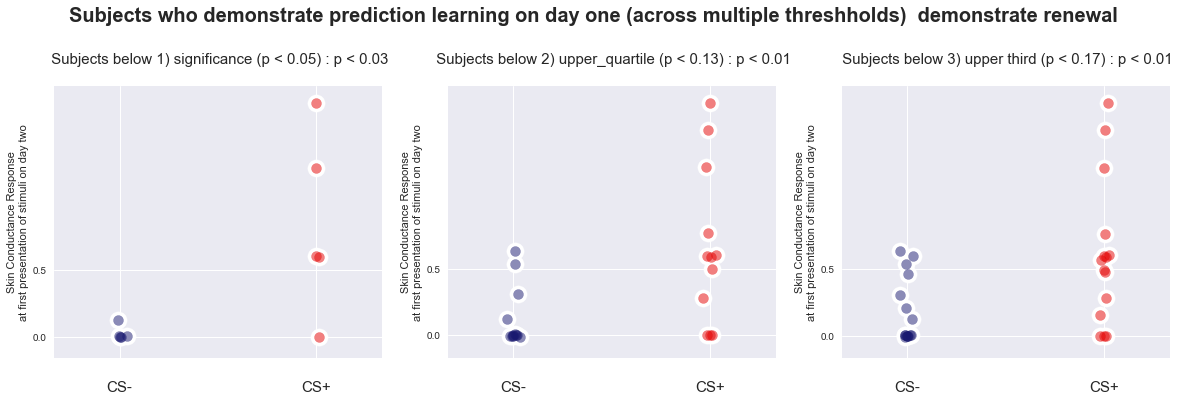

In [36]:
onset_significance = partition_analysis(conditioning['trans_onset'], renewal['trans_onset'], 'prediction', 'study_one')

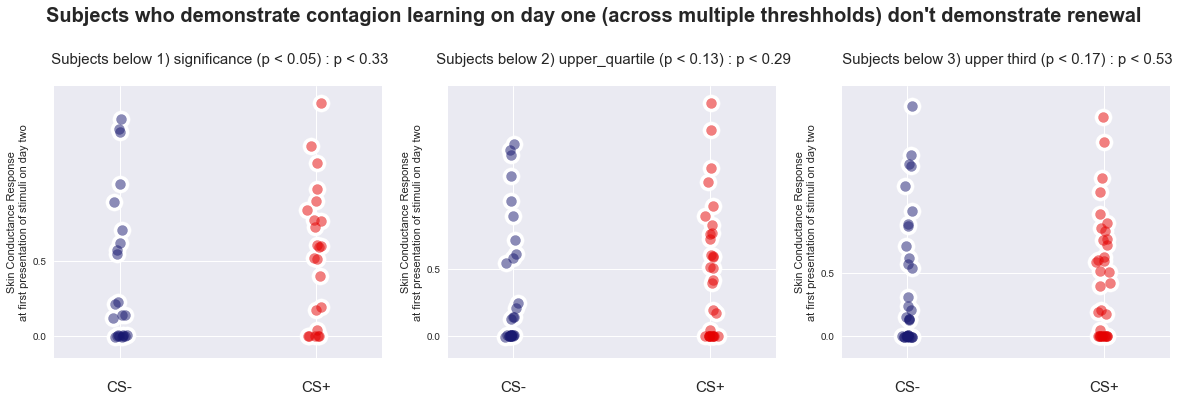

In [37]:
offset_significance = partition_analysis(conditioning['trans_offset'], renewal['trans_onset'], 'contagion', 'study_one')

In [38]:
cond_sig_on = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_on[i_subject] = scipy.stats.ttest_ind(conditioning['trans_onset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_onset']['negative_stim'][i_subject,:])[1];
    
cond_sig_off = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_off[i_subject] = scipy.stats.ttest_ind(conditioning['trans_offset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_offset']['negative_stim'][i_subject,:])[1];

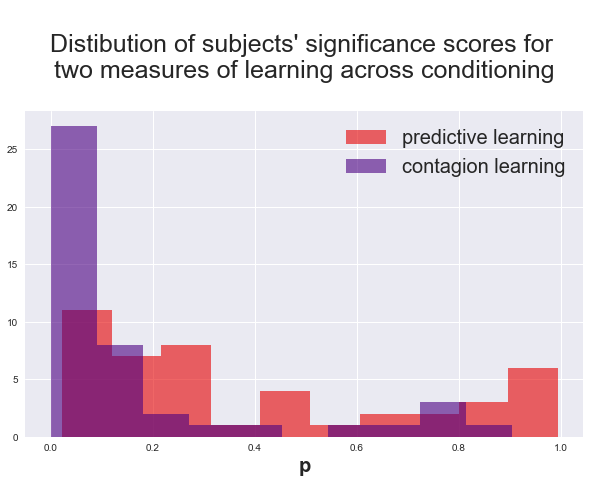

In [39]:
figure(figsize=[10,6])
hist(cond_sig_on, alpha=.6, label='predictive learning', color='xkcd:red')
hist(cond_sig_off, alpha=.6, label='contagion learning', color='indigo'); 
legend(fontsize=20)
title("\nDistibution of subjects' significance scores for \ntwo measures of learning across conditioning\n", fontsize=25); 
xlabel('p', fontweight='bold', fontsize=20); 

In [40]:
self_report, subject_names = behavioral_functions.generate_data_frame(behavioral_data_path)

In [41]:
SCR_all = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'], 
                            'prediction':conditioning['trans_onset']['learning'], 
                            'contagion':conditioning['trans_offset']['learning'], 
                            'order':abs(1-counter_balance_info['order']), 
                            'contagion_initial': conditioning['trans_onset']['initial_difference_contagion']}) 

SCR_all['subject_names'] = [day_two.subjectNames[ii][0:4] for ii in range(day_two.nSubjects)]

In [42]:
for ii in range(len(SCR_all)): 
    name = SCR_all.subject_names.values[ii]
    found = 0
    for jj in range(len(self_report)): 
        if name in self_report.index.values[jj]: 
            found = 1
    if found == 0 : 
        missing_subject = ii

In [43]:
SCR_all = SCR_all.drop(missing_subject)
onset_significance_corrected = np.delete(onset_significance, missing_subject)
offset_significance_corrected = np.delete(offset_significance, missing_subject)

In [44]:
tmp_data = {}
indices = [] 
for ii in range(len(SCR_all.keys())): 
    tmp_data[SCR_all.keys()[ii]] = SCR_all[SCR_all.keys()[ii]].values

for ii in range(len(self_report.keys())): 
    tmp_data[self_report.keys()[ii]] = self_report[self_report.keys()[ii]].values

In [45]:
physio_selfreport = pandas.DataFrame.from_dict(tmp_data)

In [46]:
physio_selfreport.correctColor = physio_selfreport.correctColor.values * 1

In [47]:
cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(':', '') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

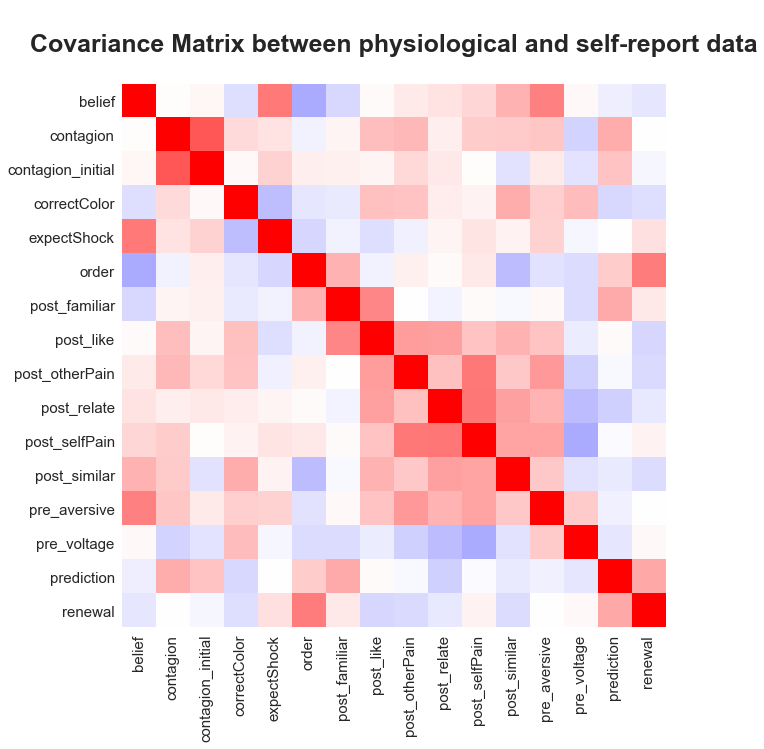

In [48]:
sns.set_style("dark", {'axes.grid' : False})
figure(figsize=[10,10])
whole_corr = physio_selfreport.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks(range(0,len(whole_corr.keys())),whole_corr.keys(), fontsize=15); 
xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
title('\nCovariance Matrix between physiological and self-report data\n', fontsize=25, fontweight='bold')
savefig('%scovariace_matrix_study_one.png'%results_folder)

In [49]:
# figure(figsize=[20,10])
# subplot(121)
# full_data_threshhold = physio_selfreport[offset_significance_corrected < offset_significance_corrected.mean(0)  ]
# whole_corr = full_data_threshhold.corr()
# imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
# yticks(range(0,len(whole_corr.keys())),whole_corr.keys(), fontsize=15); 
# xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
# title('\nCovariance Matrix between physiological and self-report data\nTop half of emotional contagion learners', fontsize=20)
# subplot(122)
# full_data_threshhold = physio_selfreport[onset_significance_corrected<onset_significance_corrected.mean(0)]
# sns.set_style("dark", {'axes.grid' : False})
# whole_corr = full_data_threshhold.corr()
# imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
# yticks([-1])
# xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
# title('\nCovariance Matrix between physiological and self-report data\nTop half of predictive learners', fontsize=20)
# suptitle('There doesnt seem to be much off diagonal structure between the physio and  behaviorla data', 
#          fontweight='bold', fontsize=25,y=1.01);
# print '\n'

In [50]:
def show_relationship(data_frame, x_var, y_var, color='indigo', alpha=.8, line_alpha=.1): 
    
    sns.set_style("dark", {'axes.grid' : False}, )

    X_ = data_frame[x_var].values
    y_ = data_frame[y_var].values
    
    keepers = np.array(X_ == X_) & np.array(y_ == y_)
    y = y_[keepers]
    X = X_[keepers]

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    xx = np.arange(min(X), max(X))
    yy = slope * xx + intercept
    sns.despine()
    # Print out the statistics
    
    if p_value < .05: plot(xx, yy, linewidth=20,alpha=line_alpha, color=color)
    scatter(X, y, s=600, color='white', alpha=1)
    scatter(X, y, s=150, color=color, alpha=alpha)
    
    yticks([]); xticks([])
    xlabel(x_var, fontsize=15, fontweight='bold')
    ylabel(y_var, fontsize=15, fontweight='bold')

    title('Relating %s and %s (p < %.2f)\n'%(x_var, y_var, p_value), fontsize=15, fontweight='bold')

In [51]:
def show_gaze_relationships(_11, _12, _21, _22, _31, _32, _title_, _color_, _data_, _file_title): 
    figure(figsize=[20,5])
    subplot(1,3,1)
    show_relationship(_data_, _11, _12, color=_color_)
    subplot(1,3,2)
    show_relationship(_data_, _21, _22, color=_color_)
    subplot(1,3,3)
    show_relationship(_data_, _31, _32, color=_color_)
    t = suptitle(_title_, y=1.1, fontsize=25, fontweight='bold');
    savefig('%s/%s.png'%(results_folder, _file_title), bbox_inches='tight', bbox_extra_artists=[t])

In [52]:
def show_relationship_between_expectation_and_belief(): 
    figure(figsize=[6,5])
    _belief = physio_selfreport.belief.values + (np.random.random(len(physio_selfreport.belief.values ))-.5)/5
    _expect = physio_selfreport.expectShock.values + (np.random.random(len(physio_selfreport.expectShock.values ))-.5)/5
    scatter(_belief, _expect, s=200, alpha=1, color='white')
    scatter(_belief, _expect, s=100, alpha=.5, color='xkcd:indigo')
    xlim([-.2, 1.2])
    ylim([-.2, 1.2])
    xticks([0,1], ['"No"', '"Yes"'], fontsize=15, fontweight='bold')
    yticks([0,1], ['"No"', '"Yes"'], fontsize=15, fontweight='bold')
    xlabel('\n"Did you believe that the model was being shocked \nin the video you watched yesterday?"', y=.1, fontsize=11)
    ylabel('"Did you feel like you were going to be shocked \nwhen you saw the red squares today?"\n', fontsize=11)
    t = title('Only subjects who believed model was being shocked on day one\nfelt like they were going to be shocked on day two', y=1.1, fontsize=15, fontweight='bold'); 
    savefig('%sday_one_expectation_and_belief.png'%results_folder,  bbox_inches='tight', bbox_extra_artists=[t])

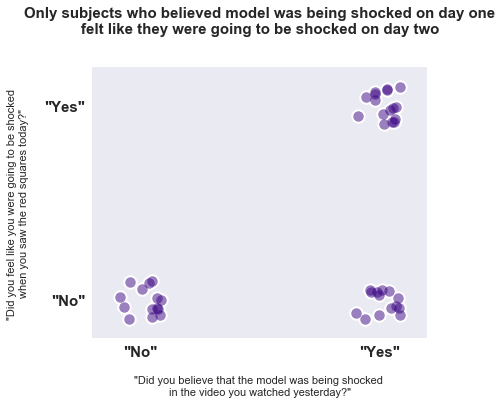

In [53]:
show_relationship_between_expectation_and_belief()

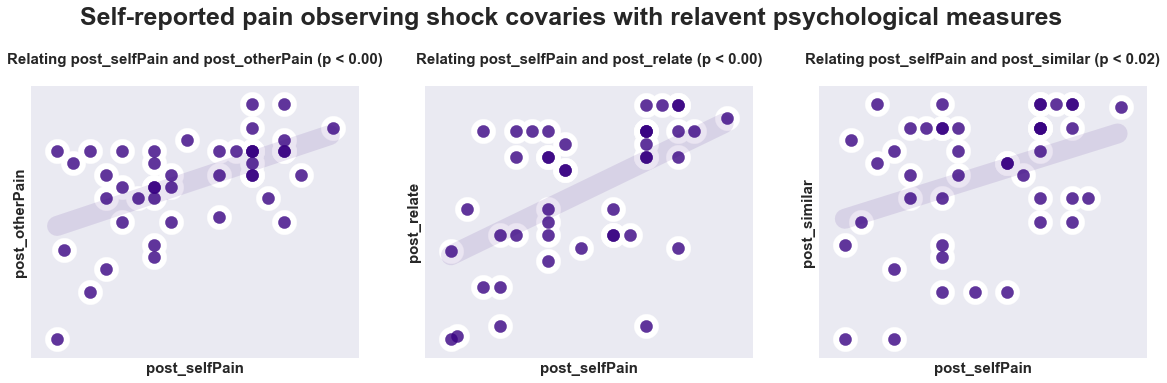

In [54]:
show_gaze_relationships('post_selfPain', 'post_otherPain', 
                        'post_selfPain', 'post_relate',
                        'post_selfPain', 'post_similar', 
                        'Self-reported pain observing shock covaries with relavent psychological measures', 
                        'xkcd:indigo', physio_selfreport, 'study_one_post_selfPain') 

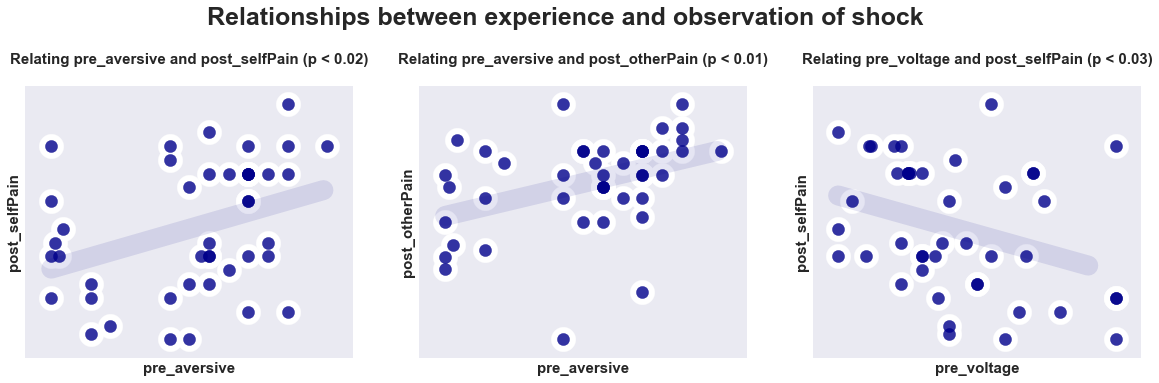

In [55]:
show_gaze_relationships('pre_aversive', 'post_selfPain', 
                        'pre_aversive', 'post_otherPain',
                        'pre_voltage' , 'post_selfPain', 
                        'Relationships between experience and observation of shock', 
                        'darkblue', physio_selfreport, 'study_one_shock_relationships') 

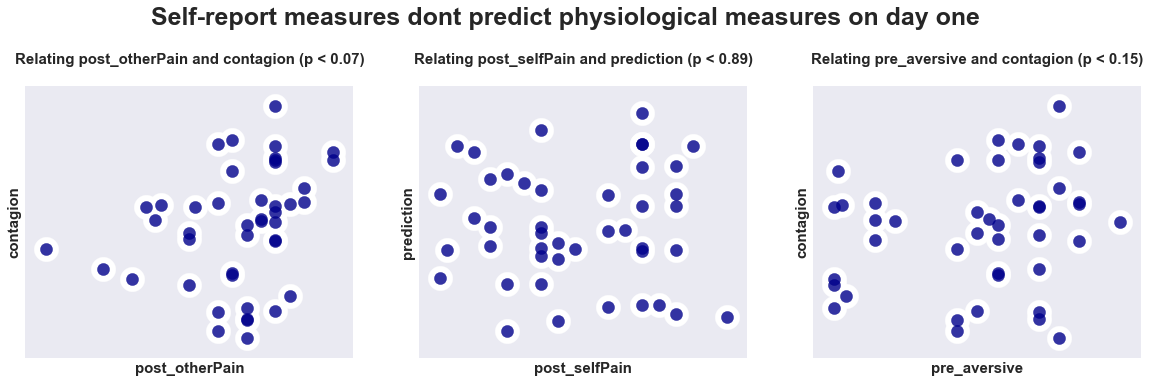

In [56]:
show_gaze_relationships('post_otherPain', 'contagion',
                        'post_selfPain', 'prediction', 
                        'pre_aversive', 'contagion',
                        'Self-report measures dont predict physiological measures on day one', 
                        'darkblue', physio_selfreport, 'study_one_self_report_non_physio') 

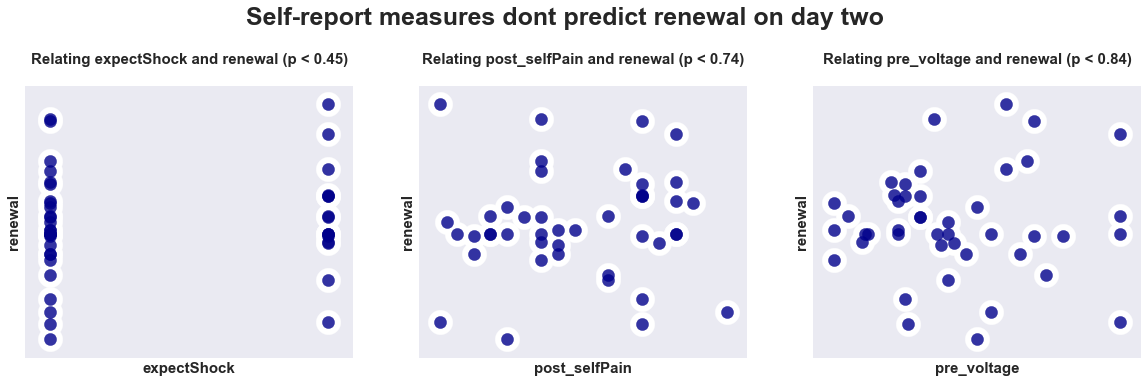

In [57]:
show_gaze_relationships('expectShock','renewal', 
                        'post_selfPain', 'renewal', 
                        'pre_voltage', 'renewal',
                        'Self-report measures dont predict renewal on day two', 
                        'darkblue', physio_selfreport, 'day_one_self_report_non_renewal') 

In [58]:
physio_selfreport.keys()

Index([u'belief', u'color', u'contagion', u'contagion_initial',
       u'correctColor', u'expectShock', u'first', u'order', u'post_color',
       u'post_familiar', u'post_like', u'post_otherPain', u'post_relate',
       u'post_selfPain', u'post_similar', u'pre_aversive', u'pre_voltage',
       u'prediction', u'renewal', u'subject_names', u'third'],
      dtype='object')

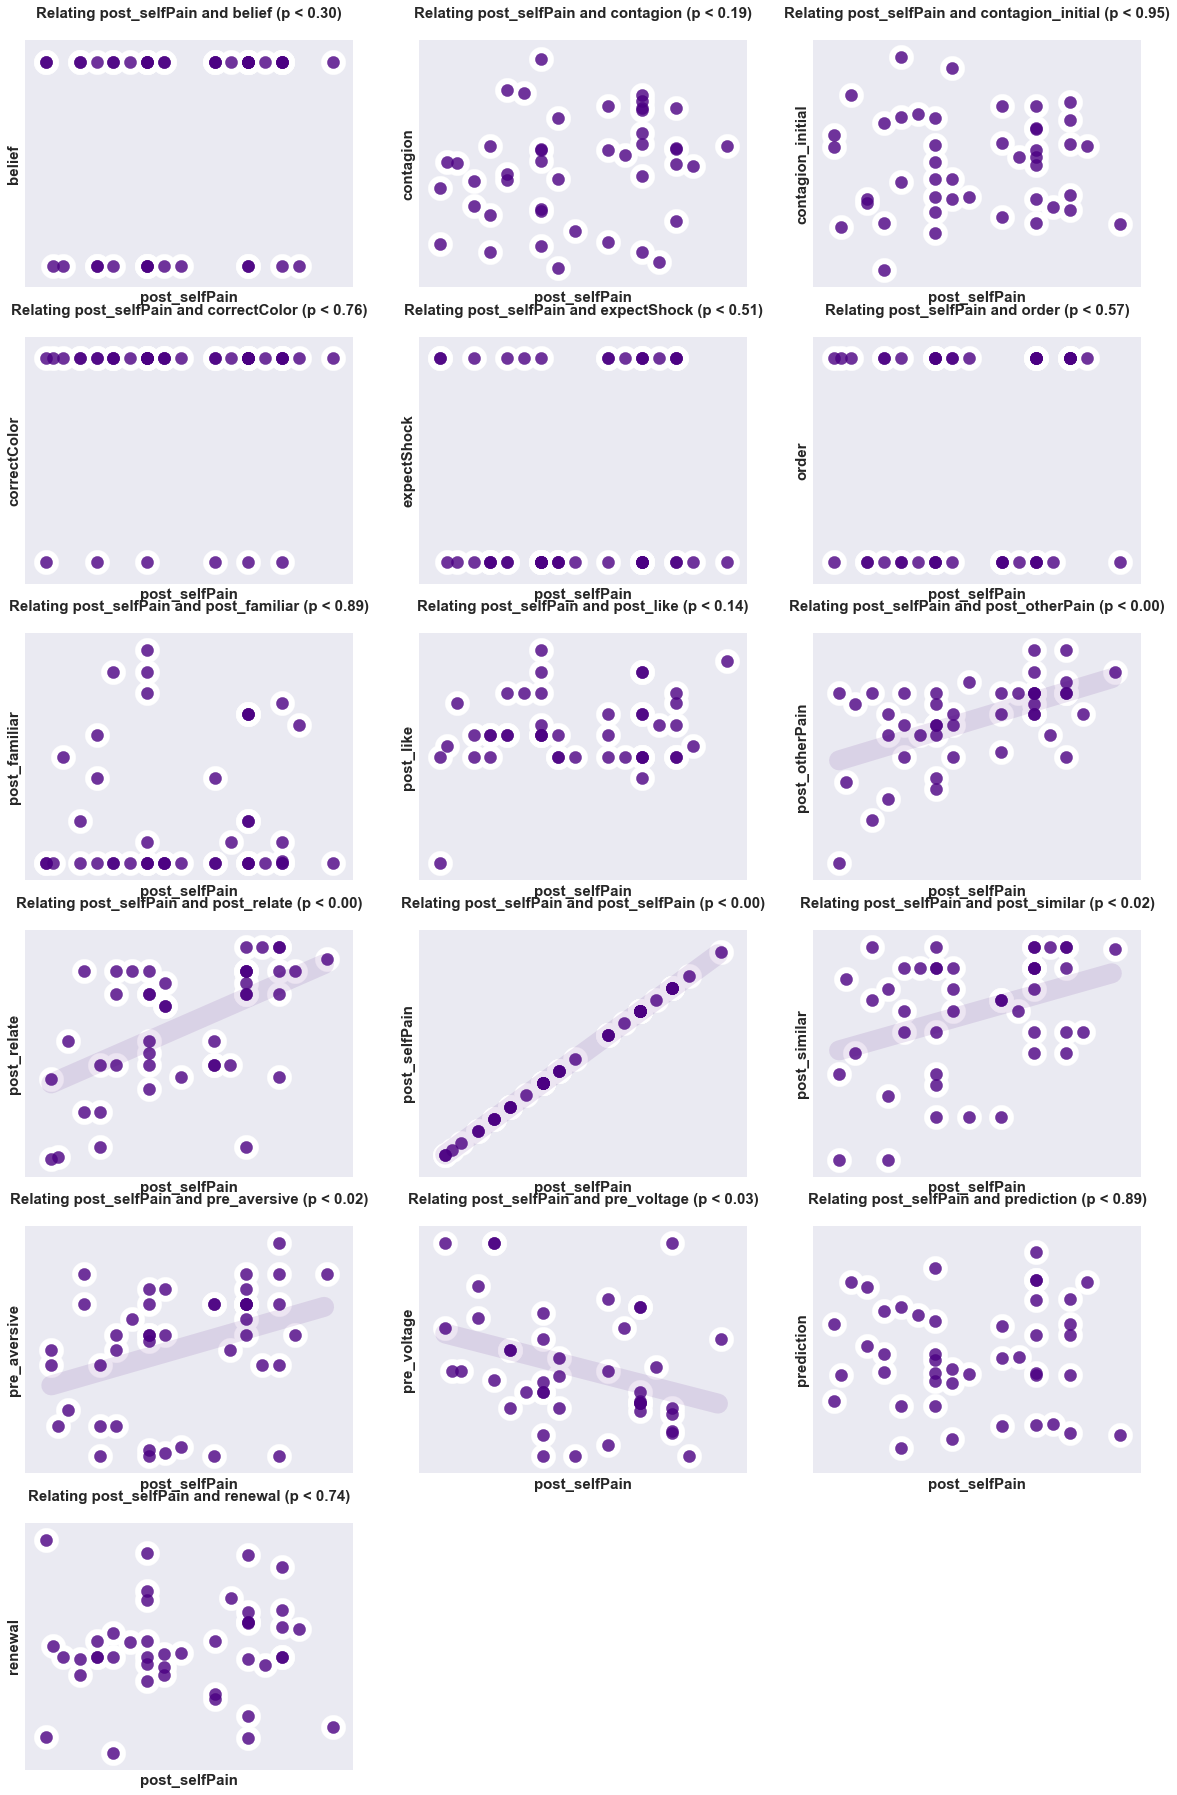

In [59]:
figure(figsize=[20,60+10])
avoid = ['first', 'color', 'post_color', 'subject_names', 'third']
count = 1
for ii in physio_selfreport.keys():
    if ii not in avoid: 
        subplot(13,3,count) ; count = count + 1 
        show_relationship(physio_selfreport, 'post_selfPain', ii)

In [60]:
_tmp = os.listdir('/Users/biota/Desktop/sSL/general/data_analyses/data/selfReportData/')
_tmp = [_tmp[ii] for ii in range(len(_tmp)) if 'part1' in _tmp[ii]] 
_tmp.sort() 

In [61]:
i_show = 35
a = np.load('/Users/biota/Desktop/sSL/general/data_analyses/data/selfReportData/%s'%_tmp[i_show]).item()
i_ind = selfReport['subject names'][selfReport['subject names'].values == _tmp[i_show][0:-10]].index[0]

NameError: name 'selfReport' is not defined

In [ ]:
selfReport.loc[i_show]

In [ ]:
perspective_taking = np.zeros(len(self_report)) * np.nan
fantasy = np.zeros(len(self_report)) * np.nan
empathic_concern = np.zeros(len(self_report)) * np.nan
personal_distress = np.zeros(len(self_report)) * np.nan

In [ ]:
search_through = np.array(zip(self_report['post: otherPain'], self_report['post: similar'], self_report['pre: voltage']))

for i_ind in range(1, len(self_report)): 
    
    search_for = np.array(zip(selfReport.loc[i_ind][['post: otherPain']], 
                              selfReport.loc[i_ind][['post: similar']], 
                              selfReport.loc[i_ind][['pre: voltage']]))

    a = np.nonzero(sum(search_through  == search_for, axis=1) == len(search_for_this[0]))[0]
    
    if len(a) == 1: 

        perspective_taking[a[0]] = selfReport.loc[i_ind][['perspective-taking']].values[0]
        fantasy[a[0]] = selfReport.loc[i_ind][['fantasy']].values[0]
        empathic_concern[a[0]] = selfReport.loc[i_ind][['empathic concern']].values[0]
        personal_distress[a[0]] = selfReport.loc[i_ind][['personal distress']].values[0]

In [ ]:
self_report['perspective_taking'] = perspective_taking
self_report['fantasy'] = fantasy
self_report['empathic_concern'] = empathic_concern
self_report['personal_distress'] = personal_distress

In [ ]:
self_report['personal_distress'].hist()

In [ ]:
# load subject names
reportPath = '/Users/biota/Desktop/sSL/general/data_analyses/data/selfReportData/'
tmpFiles = os.listdir(reportPath)
subjectNames = []

for file in tmpFiles: 
    if str.find(file, 'part1') != -1: 
        subjectNames.append(file[0:-10])

# load question names to search for 
selfReportPath = '/Users/biota/Desktop/sSL/general/data_analyses/data/selfReportData/'
fileNames = os.listdir(selfReportPath)

this = np.load('%s/%s'%(selfReportPath,fileNames[3])).item()
day2Q = list(this.keys())

this = np.load('%s/%s'%(selfReportPath,fileNames[2])).item()
day1Q = list(this.keys())

days = [day1Q,day2Q]

In [ ]:
selfReport = pandas.DataFrame({'subject names':subjectNames})

for iDay in range(0,len(days)): 
    for iQ in range(0,len(days[iDay])): 
        q = days[iDay][iQ]
        iResponse = [None] * len(subjectNames) # np.empty(len(subjectNames)) * np.nan
        for iSubject in range(0,len(subjectNames)):
            for iFile in fileNames:
                if str.find(iFile, subjectNames[iSubject]) != -1:
                    try: 
                        tmp = np.load('%s%s'%(selfReportPath,iFile)).item()
                        for iQ in range(0,len(tmp)):
                            if list(tmp.keys())[iQ] == q:
                                iResponse[iSubject] = list(tmp.values())[iQ]
                    except: 
                        #print('excluding an entry from %s'%subjectNames[iSubject])
                        pass
        
        selfReport[q] = iResponse

In [ ]:
# clean up some of the errors people made entering the data
selfReport['pre: voltage'][8] = 10 # or could have been 1.1
selfReport['pre: voltage'][2] = 7
selfReport['pre: voltage'][4] = 5. 
selfReport['pre: voltage'][46] = 5
selfReport['pre: voltage'][17] = nan; 
# selfReport['pre: voltage'][25] = nan; 
# selfReport['pre: voltage'][32] = nan; 
selfReport['pre: voltage'] = pandas.to_numeric(selfReport['pre: voltage']); 
selfReport['pre: voltage'][35] = selfReport['pre: voltage'][35]/10
selfReport['pre: voltage'][38] = selfReport['pre: voltage'][38]/10
selfReport['pre: voltage'][51] = selfReport['pre: voltage'][51]/10

####
selfReport['correct color'] = (selfReport['post: color'] == 'red')
selfReport['believe'] = (selfReport['belief'] == 'yes')

In [ ]:
# load subject data from csv file--downloaded from qualtrics 
path2questionnaires = '/Users/biota/Desktop/sSL/general/data_analyses/data/selfReportData/IRI_allSubjects.csv'
subjectInfo = pandas.read_csv(path2questionnaires,sep='comma')

# prep data structures
IRI = []
subjectNamesIRI = []

# extract each subject's responses
for iSubject in range(2,len(subjectInfo)): 
    this = subjectInfo.values[iSubject][0]
    startInd = str.find(this,'anonymous')+10
    endInd = startInd + 55
    answer = (this[startInd:endInd:2])
    inds = [i for i in range(len(this)) if this.startswith(',', i)]
    who = this[int(inds[-1])+1:len(this)]
    IRI.append([answer,who])
    subjectNamesIRI.append(who)

inventoryNames = ['perspective-taking', # PT 
                  'fantasy',            # FS
                  'empathic concern',   # EC
                  'personal distress']  # PD

# recreate question order 
questions = ['FS', # 1. I daydream and fantasize, with some regularity, about things that might happen to me.
             'EC', # 2. I often have tender, concerned feelings for people less fortunate than me. 
             'PT-',# 3. I sometimes find it difficult to see things from the "other guy's" point of view. (PT) (-) 
             'EC', # 4. Sometimes I don't feel very sorry for other people when they are having problems. (EC) (-)
             'FS', # 5. I really get involved with the feelings of the characters in a novel. (FS)
             'PD', # 6. In emergency situations, I feel apprehensive and ill-at-ease. (PD)
             'FS-',# 7. I am usually objective when I watch a movie or play, and I don't often get completely caught up in it. (FS) (-)
             'PT', # 8. I try to look at everybody's side of a disagreement before I make a decision. (PT)
             'EC', # 9. When I see someone being taken advantage of, I feel kind of protective towards them. (EC)
             'PD', # 10. I sometimes feel helpless when I am in the middle of a very emotional situation. (PD)
             'PT', # 11. I sometimes try to understand my friends better by imagining how things look from their perspective. (PT)
             'FS-',# 12. Becoming extremely involved in a good book or movie is somewhat rare for me. (FS) (-) 
             'PD-',# 13. When I see someone get hurt, I tend to remain calm. (PD) (-)
             'EC-',# 14. Other people's misfortunes do not usually disturb me a great deal. (EC) (-)
             'PT-',# 15. If I'm sure I'm right about something, I don't waste much time listening to other people's arguments. (PT) (-)
             'FS', # 16. After seeing a play or movie, I have felt as though I were one of the characters. (FS)
             'PD', # 17. Being in a tense emotional situation scares me. (PD)
             'EC-',# 18. When I see someone being treated unfairly, I sometimes don't feel very much pity for them. (EC) (-)
             'PD-',# 19. I am usually pretty effective in dealing with emergencies. (PD) (-)
             'EC', # 20. I am often quite touched by things that I see happen. (EC)
             'PT', # 21. I believe that there are two sides to every question and try to look at them both. (PT)
             'EC', # 22. I would describe myself as a pretty soft-hearted person. (EC)
             'FS', # 23. When I watch a good movie, I can very easily put myself in the place of a leading character. (FS)
             'PD', # 24. I tend to lose control during emergencies. (PD)
             'PT', # 25. When I'm upset at someone, I usually try to "put myself in his shoes" for a while. (PT) 
             'FS', # 26. When I am reading an interesting story or novel, I imagine how I would feel if the events in the story were happening to me. (FS)
             'PD', # 27. When I see someone who badly needs help in an emergency, I go to pieces. (PD)
             'PT'] # 28. Before criticizing somebody, I try to imagine how I would feel if I were in their place. (PT)

# prep data structures
PT  = [] 
FS  = [] 
EC  = [] 
PD  = []
REV = []

# find indices for each subscale
for iQ in range(0,len(questions)): 
    if   questions[iQ][0:2] == 'PT': 
        PT.append(iQ)
    elif questions[iQ][0:2] == 'FS':
        FS.append(iQ)
    elif questions[iQ][0:2] == 'EC':
        EC.append(iQ)
    elif questions[iQ][0:2] == 'PD':
        PD.append(iQ)
    # items to be reverse scored 
    if questions[iQ][-1] == '-': 
        REV.append(iQ)
        
# prep data structures
inventory = [PT, FS, EC, PD]
IRIscores = pandas.DataFrame({'subject names':subjectNamesIRI})

for iSubscale in range(0,len(inventory)): 
    testvec = []
    testScale = inventory[iSubscale]
    for iSubject in range(0,len(subjectNamesIRI)): 
        tmpvals = np.zeros(len(testScale))
        testChoice = IRI[iSubject][0]
        for iInd in range(0,len(testScale)): 
            ind = int(testScale[iInd])
            # reverse scaled items: 0 -> 4, 4 -> 0, 3 -> 1, ... 2 -> 2 
            tmpVal = abs((ind in REV) * 4 - int(testChoice[ind]))
            tmpvals[iInd] = int(tmpVal)
        testvec.append(sum(tmpvals))
    IRIscores[inventoryNames[iSubscale]] = testvec

In [ ]:
len(IRIscores)

In [ ]:
# prep data structures
inventory = [PT, FS, EC, PD]
IRIscores = pandas.DataFrame({'subject names':subjectNamesIRI})

for iSubscale in range(0,len(inventory)): 
    testvec = []
    testScale = inventory[iSubscale]
    for iSubject in range(0,len(subjectNamesIRI)): 
        tmpvals = np.zeros(len(testScale))
        testChoice = IRI[iSubject][0]
        for iInd in range(0,len(testScale)): 
            ind = int(testScale[iInd])
            # reverse scaled items: 0 -> 4, 4 -> 0, 3 -> 1, ... 2 -> 2 
            tmpVal = abs((ind in REV) * 4 - int(testChoice[ind]))
            tmpvals[iInd] = int(tmpVal)
        testvec.append(sum(tmpvals))
    IRIscores[inventoryNames[iSubscale]] = testvec

In [ ]:

for iSubscale in range(0,len(inventory)): 
    tmpScale = []
    for iSubject in range(0,len(selfReport['subject names'])): 
        found=0
        for jSubject in range(0,len(subjectNamesIRI)):
            if str.find(selfReport['subject names'][iSubject],subjectNamesIRI[jSubject]) > -1: 
                tmpScale.append(IRIscores[inventoryNames[iSubscale]][jSubject]); found = 1
        if not found:  
            tmpScale.append(nan)
    selfReport[inventoryNames[iSubscale]] = tmpScale

In [ ]:
IRI